## AR-моделирование

Для загрузки класса ar_model.AutoReg, который применяется для обучения одномерной авторегрессионной модели порядка p, используется пакет statsmodels.tsa.

Ниже приведены некоторые из ключевых шагов, которые необходимо выполнить для обучения AR-модели:

1. Отобразить временной ряд.
2. Проверить ряд на стационарность (модель AR можно применять только к стационарному временному ряду).
3. Выбрать параметр p (порядок модели AR).
4. Обучить модель.


Autoregression modelling fro [renewable energy generation in Germany between the years 2006–2017](https://www.dataquest.io/blog/tutorial-time-series-analysis-with-pandas). 


<span style="color: green">**Features:**</span>
* <code>Date</code> — дата (в формате гггг-мм-дд);
* ``Consumption`` — потребление электроэнергии (ГВтч);
* ``Wind`` — производство ветровой энергии (ГВтч);
* ``Solar`` — производство солнечной энергии (ГВтч);
* ``Wind+Solar`` — сумма производства ветровой и солнечной энергии (ГВтч).
В качестве примера построим предсказание объёма потребления электроэнергии на три месяца (возьмём последние 100 дней).



In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.ar_model import AutoReg
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set_palette("husl")
# Display fixed length of a dataframe
pd.set_option("display.max_rows", 9, "display.max_columns", 9)

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
 
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA

#set path
import os
import sys
sys.path.insert(1, '../')
from utils.functions import Dickey_Fuller_test, plot_acf_pacf, optim_param, plot_history_regr, split_sequence
from utils.config_reader import config_reader
# Import parameters
config = config_reader('../config/config.json')
random_state = config.random_seed
path_figures = config.path_figures
path_models = config.path_models

df = pd.read_csv("../data/energy_demand_OPSD.zip", sep=",",index_col="Date", parse_dates=['Date']) 
 
df.head(2)

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2006-01-01,1069.184,NaN,NaN,NaN
2006-01-02,1380.521,NaN,NaN,NaN


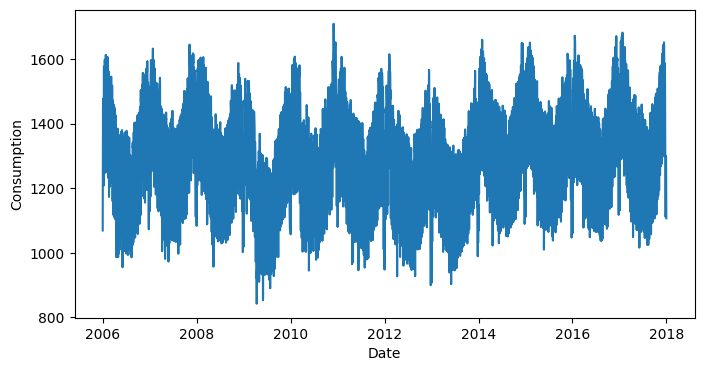

In [2]:
plt.figure(figsize=(8,4))
sns.lineplot(df, x=df.index, y='Consumption');

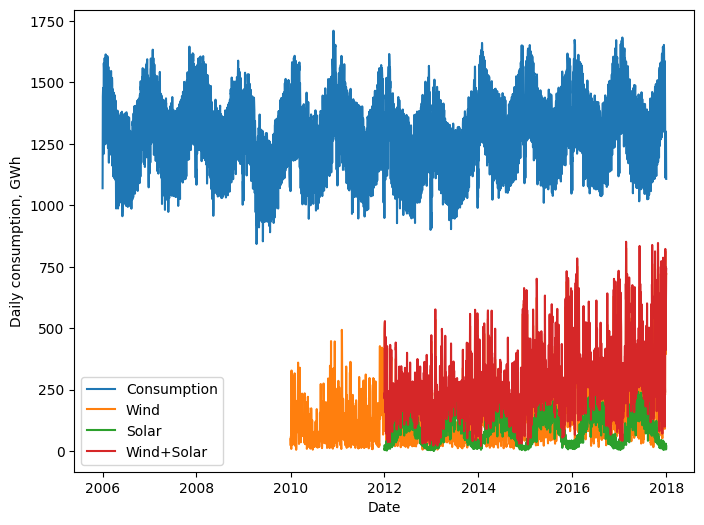

In [3]:
fig = plt.figure(figsize=(8,6))

for i,v in enumerate(df.columns):
    sns.lineplot(df, x=df.index, y=v, label=v)
plt.ylabel('Daily consumption, GWh');

> We may observe annual energy consumption in Germany. It is clear that the power demand has a remarkable seasonal component. 

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4383 entries, 2006-01-01 to 2017-12-31
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Consumption  4383 non-null   float64
 1   Wind         2920 non-null   float64
 2   Solar        2188 non-null   float64
 3   Wind+Solar   2187 non-null   float64
dtypes: float64(4)
memory usage: 171.2 KB


## Consumption change in time

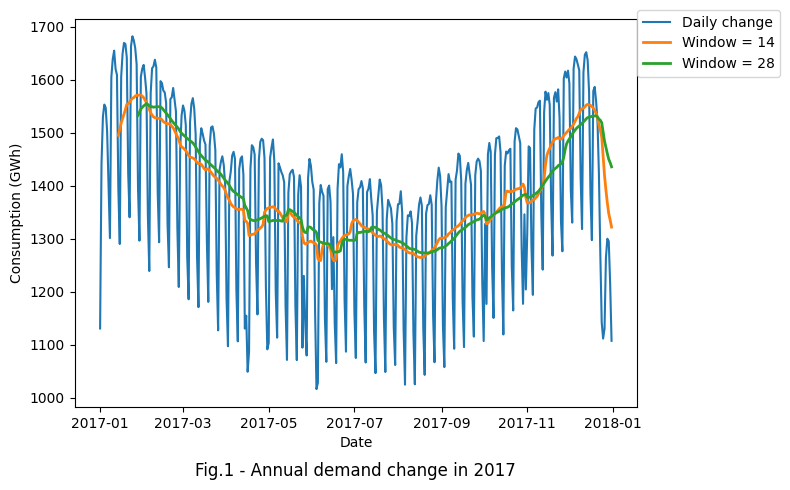

In [5]:
# calculate the weekly mean demand
#temp = df.loc['2017', 'Consumption'].reset_index().groupby(pd.Grouper(key='Date', freq='w'),as_index=False).mean().rename(columns={'Consumption':'Weekly_mean'})

fig_id = 1
plt.figure(figsize = (8,5))
#plt.subplots(figsize = (8,5))
sns.lineplot(df.loc['2017', 'Consumption'], label='Daily change');
#sns.lineplot(x=df.loc['2017', 'Consumption'].index[::7], y=temp['Weekly_mean'].values, c='r', label='Weekly_mean')

window = np.linspace(14,28,2).astype("int8") # Set 2 window sizes: 14,28
#markers = ['o', 'x']

for i in range(window.shape[0]):
    plt.plot(
        df.loc['2017', 'Consumption'].rolling(window=window[i]).mean(),
        label="Window = {}".format(window[i]),
        linewidth=2, 
    )
    
plt.legend(loc=(1,0.85))
plt.ylabel('Consumption (GWh)')
plt.title("Fig.{} - Annual demand change in 2017".format(fig_id), y=-0.2);
plt.tight_layout()

plt.savefig(os.path.join(path_figures, f'fig_{fig_id}.png'))

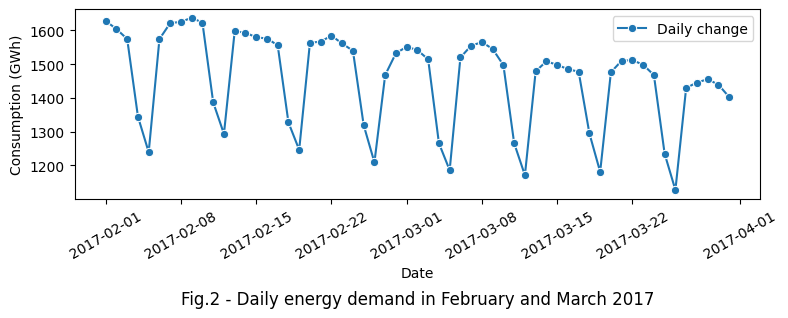

In [6]:
fig_id = 2
plt.figure(figsize = (8,4))
sns.lineplot(df.loc['2017-02':'2017-03', 'Consumption'], label='Daily change', marker='o');

#plt.legend(loc=(1,0.85))
plt.ylabel('Consumption (GWh)')
plt.xticks(rotation=30)
plt.title("Fig.{} - Daily energy demand in February and March 2017".format(fig_id), y=-0.6)
plt.tight_layout();

plt.savefig(os.path.join(path_figures, f'fig_{fig_id}.png'))

## Seasonality

In [7]:
df['month'] = df.index.month
df['weekday'] = df.index.day_name()
df[['month','weekday']].head()

,month,weekday
Date,,
2006-01-01,1,Sunday
2006-01-02,1,Monday
2006-01-03,1,Tuesday
2006-01-04,1,Wednesday
2006-01-05,1,Thursday


In [8]:
df.head(1)

,Consumption,Wind,Solar,Wind+Solar,month,weekday
Date,,,,,,
2006-01-01,1069.184,NaN,NaN,NaN,1,Sunday


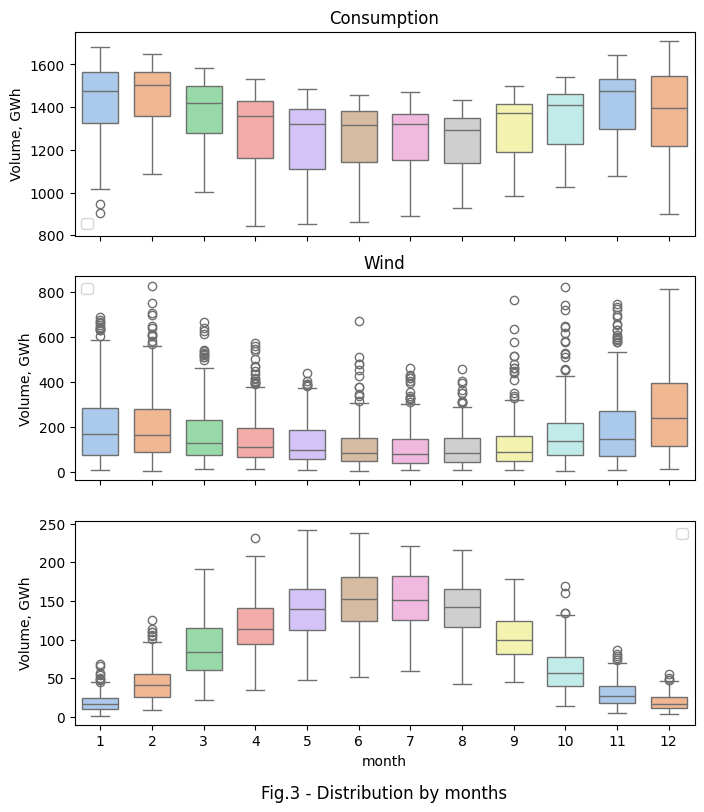

In [9]:
fig, ax = plt.subplots(3,1, figsize=(8,9), sharex=True)

for i,name in enumerate(df.columns[:3]):
    sns.boxplot(data=df, x='month', y=name, width=0.7, ax=ax[i], hue='month', palette="pastel") #palette="husl"
    ax[i].set_title(name)
    ax[i].set_ylabel('Volume, GWh')
    ax[i].legend('');
    
fig_id = 3
plt.title(f'Fig.{fig_id} - Distribution by months', y=-0.4);

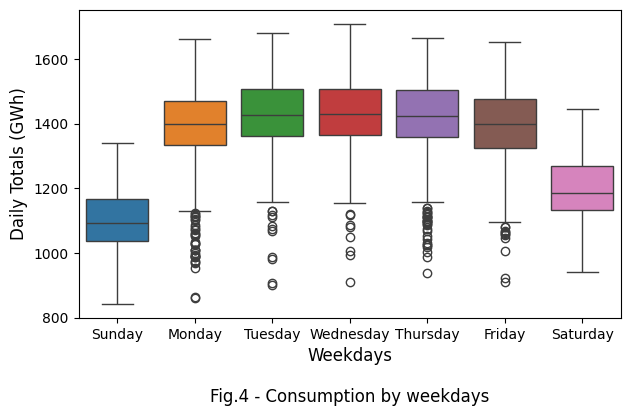

In [10]:
plt.subplots(figsize=(7,4))
sns.boxplot(df, x='weekday', y='Consumption', hue='weekday') #, c=i , palette="husl"
plt.ylabel('Daily Totals (GWh)', fontsize=12)
plt.xlabel('Weekdays', fontsize=12)

fig_id = 4
plt.title(f'Fig.{fig_id} - Consumption by weekdays', y=-0.3);

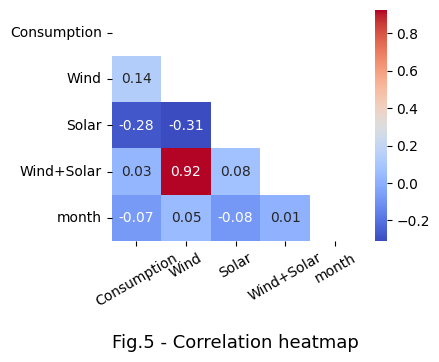

In [11]:
fig = plt.figure(figsize=(4, 3))
 
matrix = np.triu(df.corr(numeric_only=True))  
fig = sns.heatmap(df.corr(numeric_only=True), annot=True, fmt='.02f', cmap= 'coolwarm', mask=matrix) #, vmin=-1, vmax=1, center= 0
plt.xticks(rotation=30)

fig_id = 5
plt.title(f'Fig.{fig_id} - Correlation heatmap', y=-0.5, fontsize=13);

In [12]:
df.drop(['Wind+Solar'],axis=1, inplace=True) # delete the feature with high correlation
df.isna().sum()

Consumption       0
Wind           1463
Solar          2195
month             0
weekday           0
dtype: int64

In [13]:
# fig = plt.figure(figsize=(10,4))
# sns.scatterplot(df.iloc[3000:])
# fig_id = 5
# plt.title(f'Fig.{fig_id} - Features by time', y=-0.5, fontsize=13);

# Modelling

## LSTM

In [14]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense


# Hide model output
from IPython.display import clear_output

# fix random seed for reproducibility 
tf.random.set_seed(random_state)

In [15]:
# Selection
X = df[['Consumption']]

# Scaling
standardScaler = StandardScaler()

X_scaled = pd.DataFrame(
    standardScaler.fit_transform(X), 
    columns=X.columns,
    index=X.index)

X_scaled.head(3)
#processed_features.describe().round(3)

,Consumption
Date,
2006-01-01,-1.625827
2006-01-02,0.252449
2006-01-03,0.626564


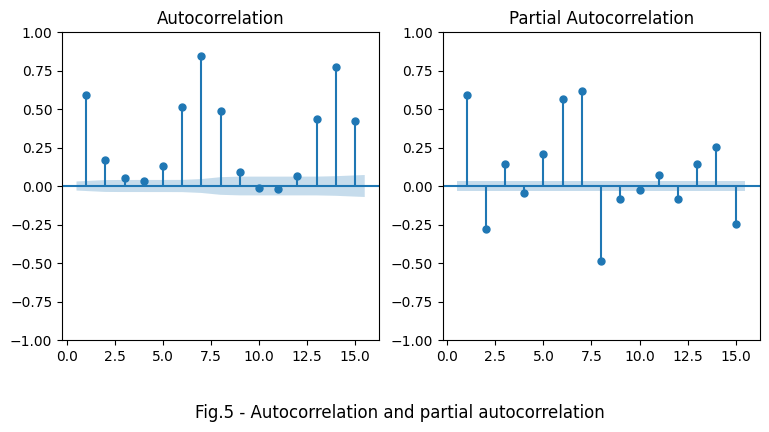

In [16]:
# check lags
plot_acf_pacf(df['Consumption'], lags=15, fig_id=5) #

In [18]:
# choose a number of time steps (every 7 days)
n_steps = 7
# split into samples
X_splitted, y_splitted = split_sequence(X_scaled.values, n_steps)
print(X_splitted.shape,  y_splitted.shape)

X_train, X_test = X_splitted[:len(X)-100], X_splitted[len(X)-100:] 
y_train, y_test = y_splitted[:len(X)-100], y_splitted[len(X)-100:]

(4376, 7, 1) (4376, 1)


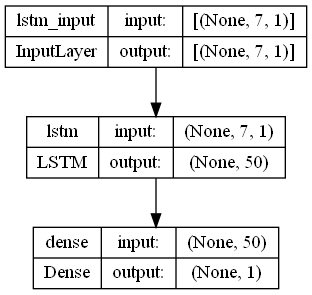

In [19]:
n_features = 1 # number of input features

# define model
model = Sequential(name='LSTM_model')
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics = ['mae', 'mse'])
tf.keras.utils.plot_model(model, show_shapes=True)

### training

In [20]:
# fit model
history = model.fit(
    X_train, 
    y_train, 
    validation_split = 0.2,
    shuffle=False,
    epochs=75, 
    verbose=True
)
clear_output(wait=False)

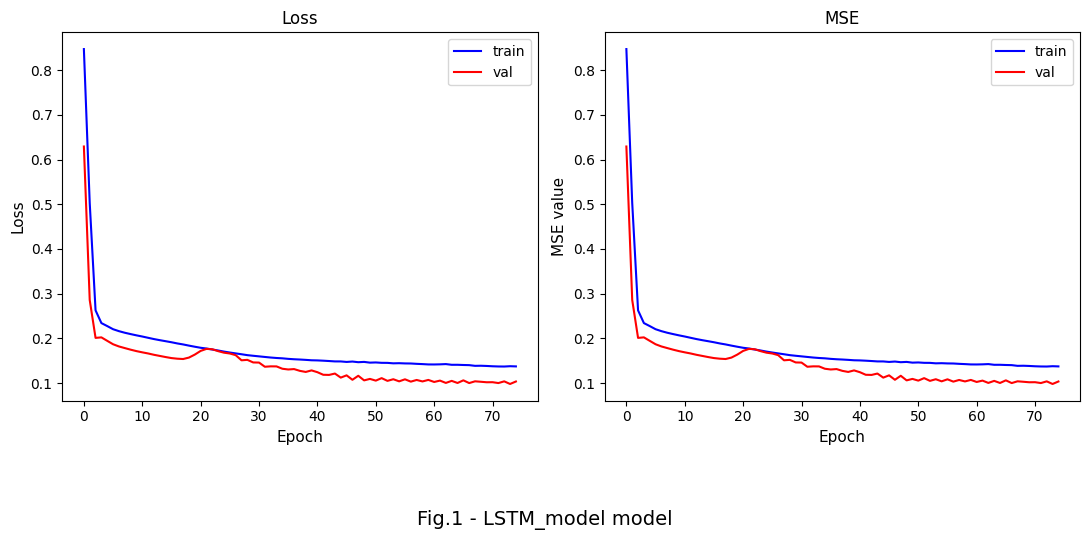

In [21]:
plot_history_regr(history = history, model_name=model.name)

In [22]:
# def build_lstm_model(lstm_units:int=100):
    
#     inputs = tf.keras.Input(shape=(X_train.shape[1],)) # input layer
    
#     x = tf.keras.layers.LSTM(units=5, return_sequences=True)(inputs)
#     x = tf.keras.layers.LSTM(units=3, return_sequences=True, dropout=0.5)(x)
#     #x = layers.Dense(8, activation='relu')(x)       # layer 3

#     predictions = layers.Dense(1, activation='relu')(x) # output layer. 
    
#     model = tf.keras.Model(inputs=inputs, outputs=predictions)
    
#     optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
        
#     model.compile(loss = 'mse', metrics = ['mae', 'mse'], optimizer = optimizer)
    
#     model.summary()
    
#     return model

# model = build_lstm_model()
# tf.keras.utils.plot_model(model, show_shapes=True)

In [23]:
# class ModelLSTM(Model):
#     """Класс создаёт модель LSTM, наследуя класс от tf.keras.
#     Параметры:
#     ----------
#     n_timesteps (_int_) - кол-во временных периодов
#     n_channels (_int_) - кол-во датчиков
#     output_units - конечный слой модели
#     lstm_units - размерность модели из конфига
#     """
#     def __init__(self, input_shape
#         #X_train: np.ndarray, x_trn_pred_dict: np.ndarray, lstm_units: int
#         ):
        
#         super().__init__()
#         # ------- параметры ------------
#         self.n_timesteps = None
#         self.n_channels = input_shape
#         self.output_units = y_pred#.shape[-1]
#         #self.n_channels = X_train_nn.shape[2]
        
#         #self.output_units = np.mean(x_trn_pred_dict[3], axis=0).shape[-1]  # среднее предсказание от 3-х моделей SRNN
        
#         #self.lstm_units = lstm_units
        
#         # -------- слои модели ----------------
#         self.input_channels = x = tf.keras.layers.Input(
#             shape=(self.n_timesteps, self.n_channels))
#         #x = tf.keras.layers.BatchNormalization()(x)
#         x = tf.keras.layers.LSTM(units=32, return_sequences=True)(x)
#         #x = tf.keras.layers.LSTM(units=self.lstm_units, return_sequences=True)(x)
#         #x = tf.keras.layers.LSTM(units=self.lstm_units, return_sequences=True)(x)
#         x = tf.keras.layers.LSTM(units=8, return_sequences=True, dropout=0.5)(x) 
#         #x = tf.keras.layers.Dense(256, activation='relu')(x)
#         #x = tf.keras.layers.BatchNormalization()(x)
#         #x = tf.keras.layers.Dropout(0.5)(x)

#         self.output_channels = tf.keras.layers.Dense(units=1, activation='relu')(x)
        
#         print(f"input_shape = {(self.n_timesteps, self.n_channels)} | output_units = {self.output_units}")

#     def build_model(self):
#         """Метод формирования модели
#         """
#         model = tf.keras.Model(
#             inputs=self.input_channels,
#             outputs=self.output_channels,
#             name="model_LSTM"
#         )        
#         model.summary()
#         return model

# model_lstm = ModelLSTM(
        
#         X_train.shape, 
#         #y_train, # numpy массив со средним значением предсказаний
#         #lstm_units=32
         
#         ).build_model() 

## Prediction

In [24]:
y_pred = model.predict(X_test)

y_pred_inverse = standardScaler.inverse_transform(y_pred)
y_test_inverse = standardScaler.inverse_transform(y_test)

print('MSE score:  {:.3f}'.format(mean_squared_error(y_pred_inverse, y_test_inverse)))
print('MAPE score: {:.3f}'.format(mean_absolute_percentage_error(y_pred_inverse, y_test_inverse)))

3/3 [==============================] - 0s 2ms/step
MSE score:  5115.115
MAPE score: 0.032


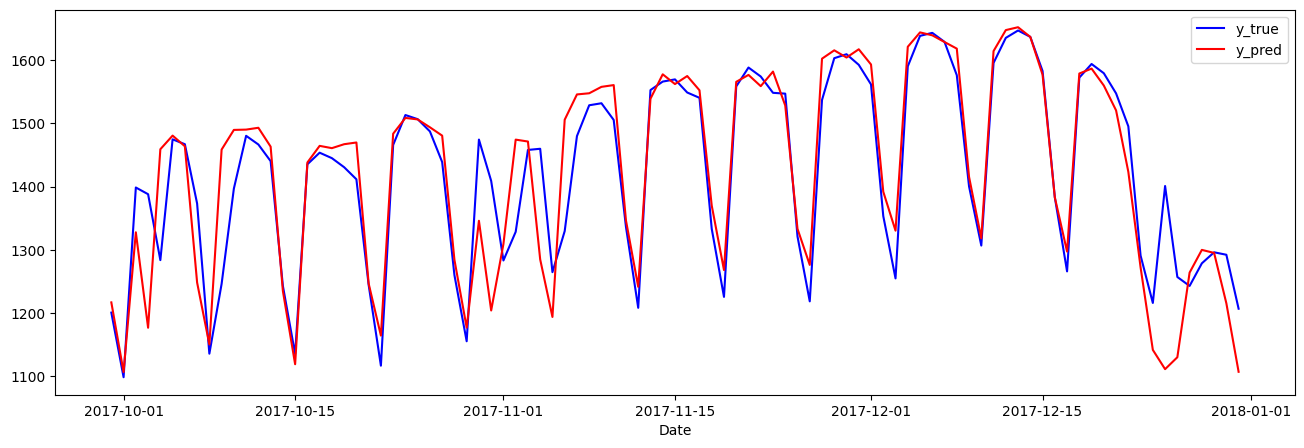

In [25]:
indexes = X.index[-y_test_inverse.shape[0]:]
length = X_test.shape[0]

plt.figure(figsize=(16,5))
sns.lineplot(
    x=indexes , 
    y=y_pred_inverse.reshape(-1,)[-length:], 
    c='b', label='y_true');
sns.lineplot(
    x=indexes, 
    y=y_test_inverse.reshape(-1,)[-length:], 
    c='r', label='y_pred');


## TF linear

In [ ]:
# # shift the target variable
# y_scaled = np.roll(X_scaled, shift=-1)

# X_train, X_test = X_scaled[:len(X)-100], X_scaled[len(X)-100:] 
# y_train, y_test = y_scaled[:len(X)-100], y_scaled[len(X)-100:] 

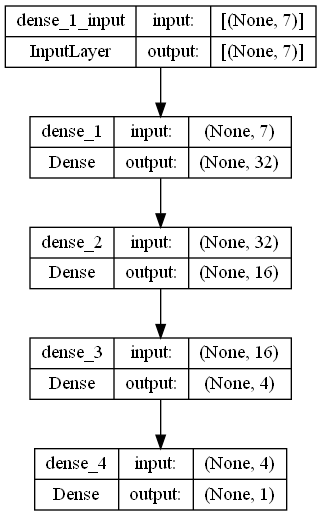

In [26]:
def build_multiple_layer_model():
    
    model = Sequential([
        Dense(32, input_shape = (X_train.shape[1],), activation = 'relu'),
        Dense(16, activation = 'relu'),
        Dense(4, activation = 'relu'),
        Dense(1)],
        name='Regression_model')
    
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
        
    model.compile(loss = 'mse', metrics = ['mae', 'mse'], optimizer = optimizer)

    
    return model

model = build_multiple_layer_model()

tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# class Regression_Model(Model):
    
#     def __init__(self, input_shape):
#         super(Regression_Model, self).__init__() # superclass initialization

#         self.d1 = layers.Dense(128, activation = 'relu', input_shape = [input_shape])
#         self.d2 = layers.Dense(64, activation = 'relu')

#         self.d3 = layers.Dense(1) #

#     def call(self, x):
        
#         x = self.d1(x)
#         x = self.d2(x)

#         x = self.d3(x)
        
#         return x
    
#     # def build_model(self):
#     #     """Метод формирования модели
#     #     """
#     #     model = tf.keras.Model(
#     #         inputs=self.input_channels,
#     #         outputs=self.output_channels,
#     #         name="model_regression"
#     #     )        
#     #     model.summary()
#     #     return model

# model = Regression_Model(X_train.shape[1]).build(X_train.shape[1]) #.build(X_train.shape[1]) #.build_model()

# model.compile(
#     optimizer = keras.optimizers.Adam(learning_rate = 0.001),
#     loss = 'mse',
#     metrics = ['mae', 'mse'])

# tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
#X_train.isna().sum()

Consumption    0
dtype: int64

In [27]:
history = model.fit(
    X_train, 
    y_train, 
    validation_split = 0.2, 
    epochs = 75,
    shuffle=False,
    
    #batch_size = 100, # load data in batches
    #callbacks = [tensorboard_callback]
);
clear_output(wait=False)

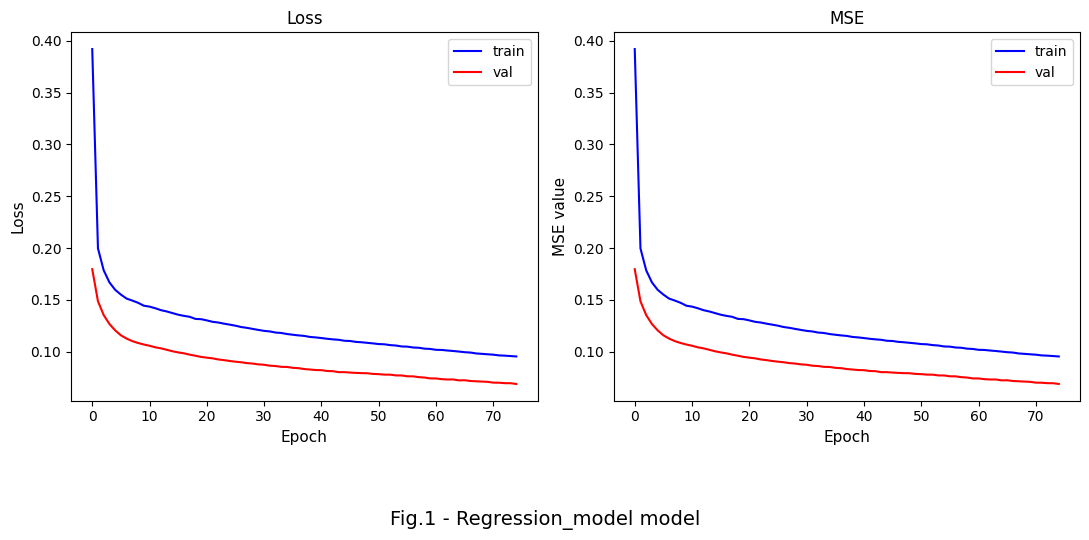

In [28]:
plot_history_regr(history=history, model_name=model.name)

In [29]:
y_pred = model.predict(X_test)
y_pred_inverse = standardScaler.inverse_transform(y_pred)
y_test_inverse = standardScaler.inverse_transform(y_test)

print('MSE score:  {:.3f}'.format(mean_squared_error(y_pred_inverse, y_test_inverse)))
print('MAPE score: {:.3f}'.format(mean_absolute_percentage_error(y_pred_inverse, y_test_inverse)))

3/3 [==============================] - 0s 1ms/step
MSE score:  2841.728
MAPE score: 0.025


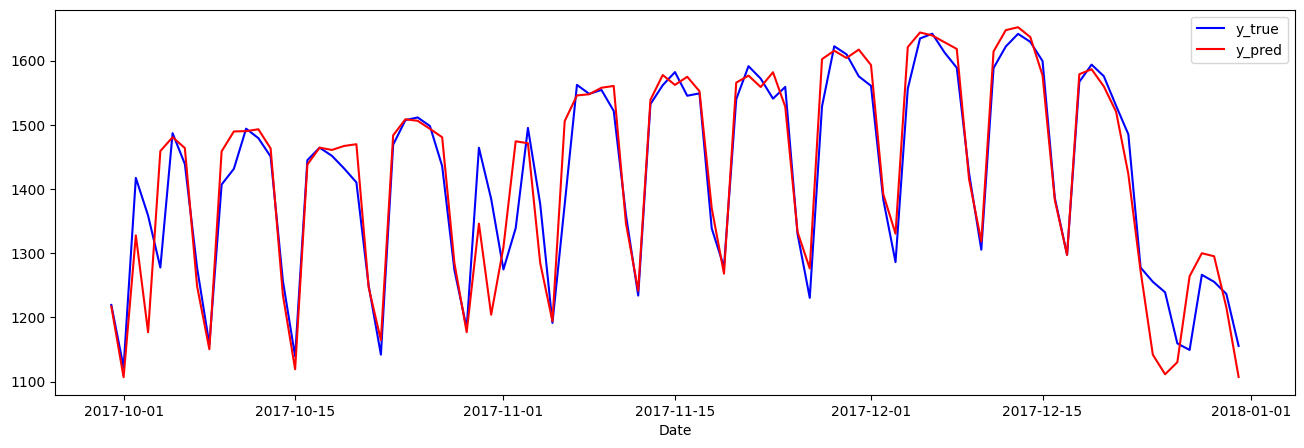

In [30]:
indexes = X.index[-y_test_inverse.shape[0]:]
length = X_test.shape[0]

plt.figure(figsize=(16,5))
sns.lineplot(
    x=indexes , 
    y=y_pred_inverse.reshape(-1,)[-length:], 
    c='b', label='y_true');
sns.lineplot(
    x=indexes, 
    y=y_test_inverse.reshape(-1,)[-length:], 
    c='r', label='y_pred');

# Other

> Let us split the dataset into samples  sequentially.

In [15]:
df = df.iloc[:,:-2]
train_data = df[:len(df)-100] #['Consumption']
test_data = df[len(df)-100:] #['Consumption']
train_data.head()

,Consumption,Wind,Solar
Date,,,
2006-01-01,1069.184,NaN,NaN
2006-01-02,1380.521,NaN,NaN
2006-01-03,1442.533,NaN,NaN
2006-01-04,1457.217,NaN,NaN
2006-01-05,1477.131,NaN,NaN


<Figure size 600x300 with 0 Axes>

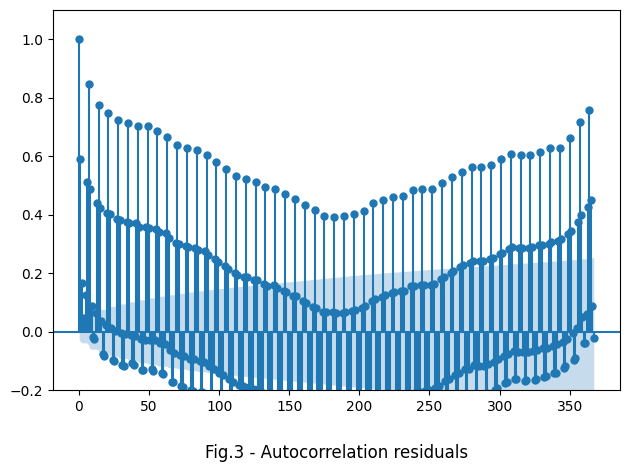

In [ ]:
fig_id = 3
fig = plt.figure(figsize=(6,3))
plot_acf(train_data['Consumption'], lags=367)

plt.title("Fig.{} - Autocorrelation residuals".format(fig_id), y=-0.2)
plt.ylim([-0.2, 1.1])
plt.tight_layout();

plt.savefig(os.path.join(path_figures, f'fig_{fig_id}.png'))

> Let us define the number of lags. As it can be seen, that high autocorrelation might be observed every 8 periods which menas lags=8 (AR(8))
>
> Fianlly, let us try to train the autoregression model.

## Autoregression model

In [ ]:
ar_model = AutoReg(train_data['Consumption'], lags=365).fit()
print(ar_model.summary())

C:\Users\Lena\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                            AutoReg Model Results                             
Dep. Variable:            Consumption   No. Observations:                 4283
Model:                   AutoReg(365)   Log Likelihood              -20660.130
Method:               Conditional MLE   S.D. of innovations             47.191
Date:                Wed, 31 Jan 2024   AIC                          42054.260
Time:                        23:30:16   BIC                          44356.574
Sample:                    01-01-2007   HQIC                         42871.230
                         - 09-22-2017                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               11.8884     24.734      0.481      0.631     -36.589      60.366
Consumption.L1       0.6421      0.016     40.235      0.000       0.611       0.673
Consumption.L2      -0.0314 

> Let us predict the test data. To do this, we need to define following arguments in the ``predict`` method: the beginning  and ending periods. In our case it will be ``len(train_data)``, which is equivalent ``len(df)-100`` because ``len(df) = len(train_data) + len(test_data)``.

C:\Users\Lena\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


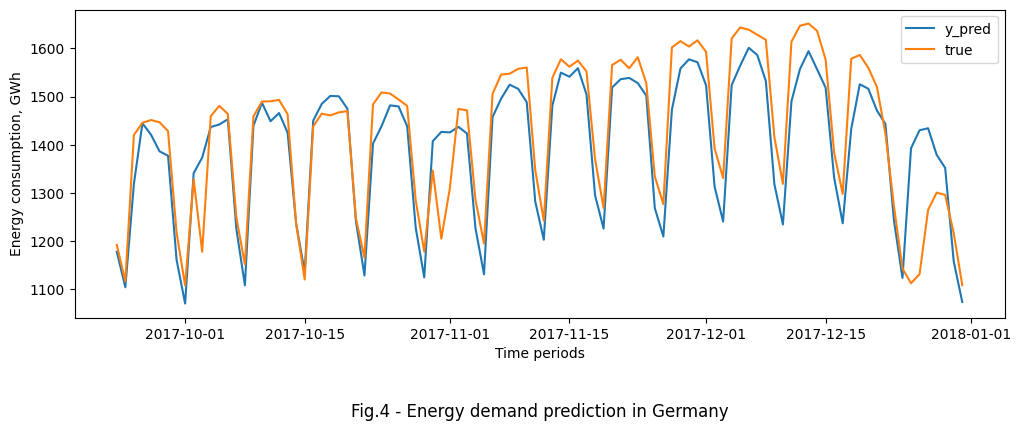

In [ ]:
# make a prediction
pred = ar_model.predict(start=test_data.index[0], end=test_data.index[-1], dynamic=False)

fig_id = 4
plt.figure(figsize=(12,4))
sns.lineplot(data=pred, label='y_pred')
sns.lineplot(data=test_data['Consumption'], label='true')
plt.xlabel('Time periods')
plt.ylabel('Energy consumption, GWh')
plt.title('Fig.{} - Energy demand prediction in Germany'.format(fig_id), y=-0.35);

plt.savefig(os.path.join(path_figures, f'fig_{fig_id}.png'))

In [ ]:
d=14
temp = df.loc[pred.index[0]-pd.DateOffset(days=d):,'Consumption'].rolling(window=d).mean().dropna().to_frame() #pd.DataFrame(, columns=['y'])
temp['ci_low'] = temp['Consumption'] - 4*temp['Consumption'].std()
temp['ci_high'] = temp['Consumption'] + 2.5*temp['Consumption'].std()

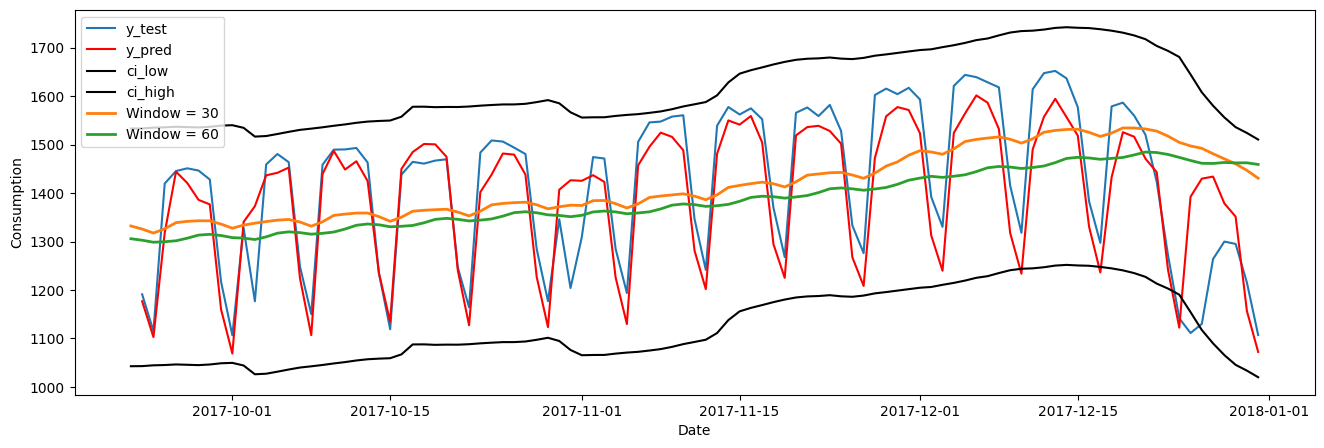

In [ ]:
#df_2017 = df.loc[pred.index[0]:,:] # restrict the
plt.figure(figsize=(16,5))
sns.lineplot(test_data, x=test_data.index, y='Consumption', label='y_test')
sns.lineplot(x=pred.index, y=pred, c='r', label='y_pred');
sns.lineplot(x=temp.index, y=temp['ci_low'], c='k', label='ci_low');
sns.lineplot(x=temp.index, y=temp['ci_high'], c='k', label='ci_high');

window = [30,60]
for i,d in enumerate(window):
    plt.plot(
        df.loc[pred.index[0]-pd.DateOffset(days=d):,'Consumption'].rolling(window=d).mean(),
        label="Window = {}".format(window[i]),#
        linewidth=2, 
    )
plt.legend();

In [ ]:
from sklearn.metrics  import  mean_squared_error, mean_absolute_percentage_error

print('MSE score:  {:.3f}'.format(mean_squared_error(test_data['Consumption'], pred)))
print('MAPE score: {:.3f}'.format(mean_absolute_percentage_error(test_data['Consumption'], pred)))

MSE score:  5938.767
MAPE score: 0.042


<Axes: xlabel='day_of_year', ylabel='Consumption'>

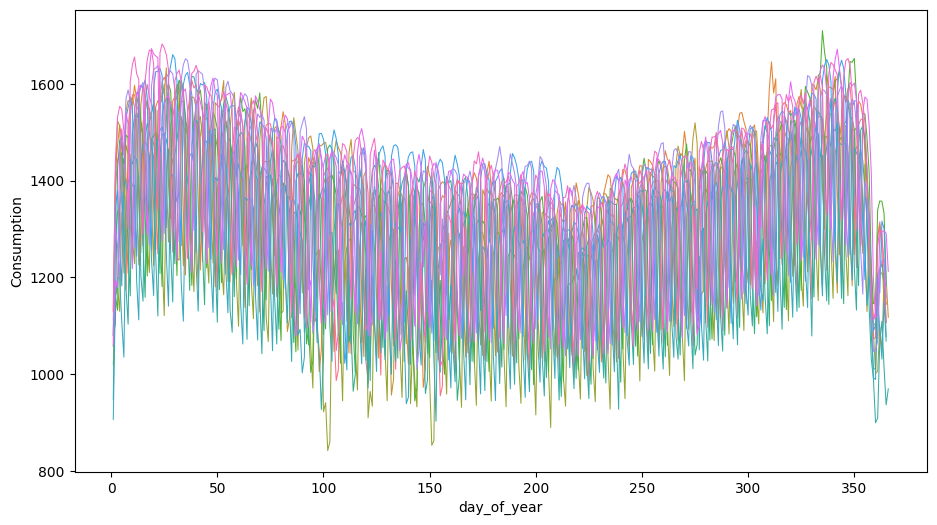

In [ ]:
# def seasonal_plot(X, y, period, freq, ax=None):
#     if ax is None:
#         _, ax = plt.subplots()
#     palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
#     ax = sns.lineplot(
#         x=freq,
#         y=y,
#         hue=period,
#         data=X,
#         ci=False,
#         ax=ax,
#         palette=palette,
#         legend=False,
#     )
#     ax.set_title(f"Seasonal Plot ({period}/{freq})")
#     for line, name in zip(ax.lines, X[period].unique()):
#         y_ = line.get_ydata()[-1]
#         ax.annotate(
#             name,
#             xy=(1, y_),
#             xytext=(6, 0),
#             color=line.get_color(),
#             xycoords=ax.get_yaxis_transform(),
#             textcoords="offset points",
#             size=14,
#             va="center",
#         )
#     return ax

# # X = tunnel.copy()

# # # days within a week

# df['year'] = df['Consumption'].index.year # year
# df['day_of_year'] = df['Consumption'].index.day_of_year  # days within a year
# fig = plt.figure(figsize=(11, 6))
# #seasonal_plot(X, y="NumVehicles", period="week", freq="day", ax=ax0)
# #seasonal_plot(df, y="Consumption", period='year', freq="dayofyear");

# palette = sns.color_palette("husl", n_colors=df['year'].nunique(),)
# # sns.scatterplot(
# #     data=df, x='day_of_year', y="Consumption", hue="year", legend=False, palette=palette, size=5,
# #     )

# sns.lineplot(
#     data=df, x='day_of_year', y="Consumption", hue="year", legend=False, 
#     palette=palette, size=5);

<Figure size 1200x1400 with 0 Axes>

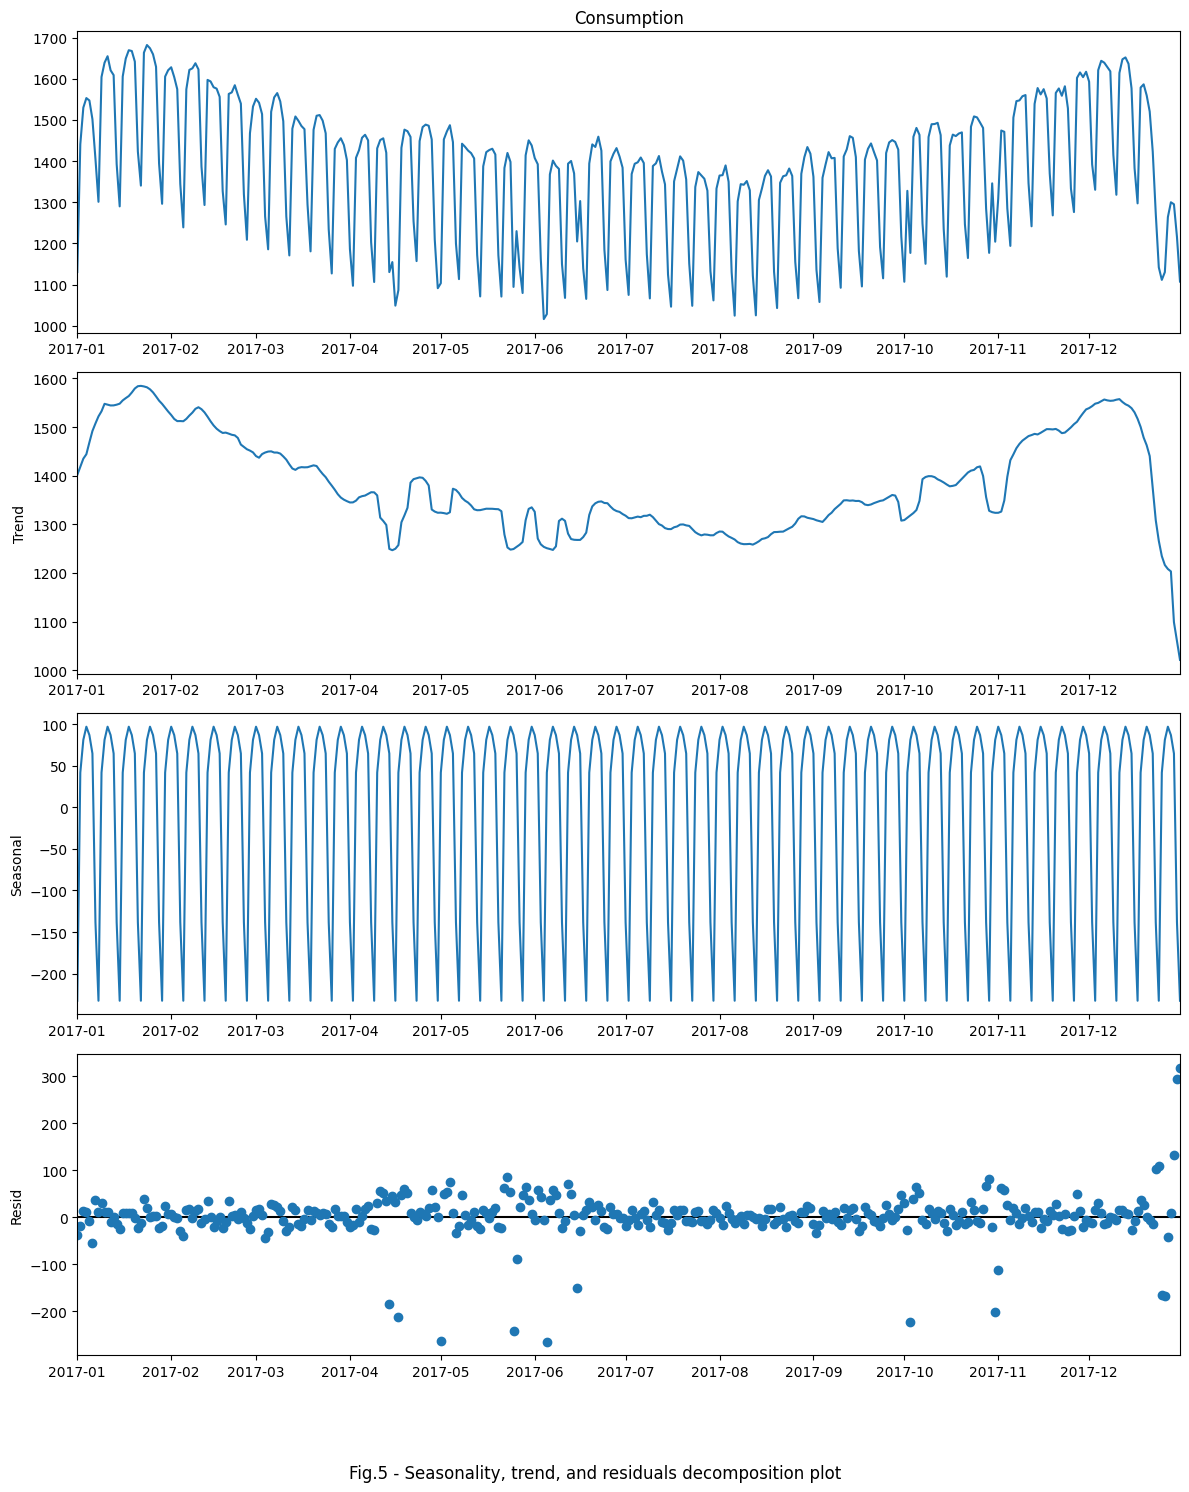

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
plt.figure(figsize=(12,14))
# Decomposition
decomposition = seasonal_decompose(df[df.index.year==2017]['Consumption'],  extrapolate_trend='freq').plot() #

fig_id = 5
plt.suptitle("Fig.{} - Seasonality, trend, and residuals decomposition plot".format(fig_id), y=-0.05)
plt.show();
#decomposition.plot();

In [ ]:
train_diff, diff_order = Dickey_Fuller_test(train_data['Consumption'])

ADF Statistic: -6.12
p-value: 9e-08
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Stationary series
Diff order = 0


C:\Users\Lena\AppData\Local\Temp\ipykernel_7904\3253696076.py:3: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  fs = pd.Timedelta("1Y") / pd.Timedelta("1D")


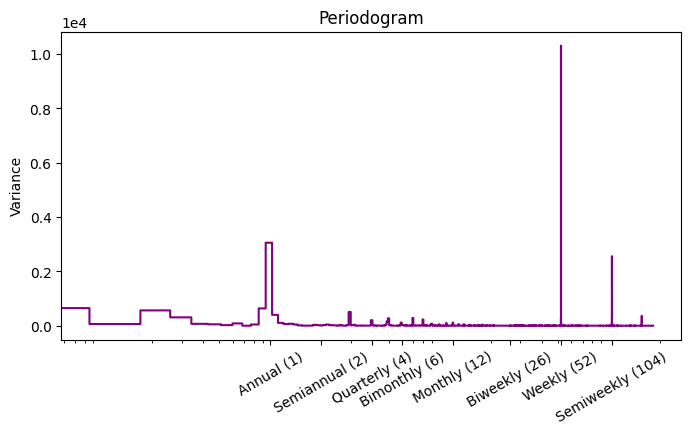

In [ ]:
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots(figsize=(8,4))
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

plot_periodogram(train_data['Consumption']);

## ARIMA model

In [ ]:
p = 14 # last significant lag taken from the partial autocorrelation graph
d = 1 # difference order
q = 7 # last significant lag taken from the  autocorrelation graph
arima_model = ARIMA(train_data['Consumption'], order=(p, d, q))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

C:\Users\Lena\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Lena\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Lena\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Lena\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Lena\AppData\Roaming\Python\Python310\site-packages\s

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            Consumption   No. Observations:                 4283
Model:               ARIMA(50, 1, 28)   Log Likelihood              -23276.248
Date:                Fri, 26 Jan 2024   AIC                          46710.496
Time:                        23:12:15   BIC                          47213.108
Sample:                    01-01-2006   HQIC                         46888.043
                         - 09-22-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1282      0.593     -0.216      0.829      -1.291       1.035
ar.L2         -0.0461      0.643     -0.072      0.943      -1.306       1.214
ar.L3      -3.989e-05      0.598  -6.67e-05      1.000      -1.171       1.171
ar.L4         -0.0210      0.513     -0.041      0.967      -1.026       0.984
ar.L5          0.0721      0.428      0.168      0.866      -0.767       0.912
ar.L6          0.0801      0.359      0.223      0.824      -0.624       0.785
ar.L7          0.0514      0.273      0.188      0.851      -0.484       0.587
ar.L8         -0.1018      0.238     -0.427      0.670      -0.569       0.366
ar.L9         -0.0540      0.203     -0.266      0.790      -0.452       0.344
ar.L10         0.0295      0.210      0.141      0.888      -0.382       0.441
ar.L11        -0.0897      0.208     -0.432      0.666      -0.496       0.317
ar.L12        -0.1191      0.186     -0.640      0.522      -0.484       0.246
ar.L13        -0.0584      0.184     -0.317      0.751      -0.419       0.302
ar.L14         0.1078      0.185      0.583      0.560      -0.255       0.470
ar.L15         0.0225      0.193      0.117      0.907      -0.356       0.401
ar.L16        -0.1440      0.174     -0.828      0.408      -0.485       0.197
ar.L17        -0.0769      0.119     -0.646      0.518      -0.310       0.156
ar.L18         0.0242      0.116      0.209      0.834      -0.203       0.251
ar.L19        -0.0445      0.118     -0.378      0.706      -0.276       0.187
ar.L20        -0.0673      0.117     -0.575      0.565      -0.297       0.162
ar.L21         0.2057      0.111      1.860      0.063      -0.011       0.422
ar.L22         0.0941      0.160      0.588      0.557      -0.220       0.408
ar.L23         0.0586      0.187      0.314      0.754      -0.308       0.425
ar.L24        -0.1389      0.202     -0.686      0.493      -0.536       0.258
ar.L25        -0.0203      0.165     -0.123      0.902      -0.343       0.303
ar.L26        -0.0675      0.122     -0.551      0.581      -0.308       0.173
ar.L27        -0.1364      0.114     -1.193      0.233      -0.360       0.088
ar.L28         0.1667      0.150      1.108      0.268      -0.128       0.462
ar.L29         0.0088      0.068      0.130      0.897      -0.124       0.141
ar.L30         0.0458      0.065      0.706      0.480      -0.081       0.173
ar.L31        -0.0057      0.055     -0.103      0.918      -0.114       0.102
ar.L32        -0.0144      0.058     -0.250      0.802      -0.127       0.099
ar.L33         0.0472      0.058      0.807      0.419      -0.067       0.162
ar.L34         0.0127      0.048      0.266      0.790      -0.081       0.107
ar.L35         0.0374      0.043      0.870      0.384      -0.047       0.122
ar.L36        -0.0531      0.047     -1.136      0.256      -0.145       0.039
ar.L37         0.0085      0.057      0.149      0.881      -0.103       0.120
ar.L38         0.0551      0.049      1.130      0.259      -0.040       0.151
ar

In [ ]:
result = optim_param(data=train_data['Consumption'], field=np.arange(6,8))
result.head()

In [ ]:
import pmdarima as pm

smodel = pm.auto_arima(
    train_data['Consumption'], # unchanged dataset!!!
    start_p=7, max_p=14, start_P=0,
    d=1, D=1, m=1,
    start_q=25, max_q=28, 
    test="adf",
    error_action="ignore",
    trace=True,seasonal=False
)

smodel.summary()

Performing stepwise search to minimize aic


In [ ]:
# substitute optimal parameters (mine seems to me better)
arima_model = ARIMA(train_data['Consumption'], order=(14, 1, 7))
arima_model = arima_model.fit()
arima_pred = arima_model.predict(start=test_data.index[0], end=test_data.index[-1])
arima_pred

C:\Users\Lena\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Lena\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Lena\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Lena\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Lena\AppData\Roaming\Python\Python310\site-packages\s

2017-09-23    1201.277875
2017-09-24    1118.638065
2017-09-25    1397.678660
2017-09-26    1426.073277
                 ...     
2017-12-28    1438.387859
2017-12-29    1385.872776
2017-12-30    1216.854201
2017-12-31    1162.138546
Freq: D, Name: predicted_mean, Length: 100, dtype: float64

In [ ]:
# forecast = arima_model.conf_int(alpha=0.05)
forecast_df = arima_model.get_forecast(len(test_data.index))
forecast_df = forecast_df.conf_int(alpha=0.05) # Confidence level of 95%
forecast_df.head(2)

,lower Consumption,upper Consumption
2017-09-23,1081.164158,1321.391592
2017-09-24,973.003806,1264.272325


In [ ]:
prediction_arima = pd.DataFrame({
    'y': test_data['Consumption'].values.ravel(),
    'y_hat': arima_pred.values,
    'ci_lower': forecast_df.iloc[:,0],
    'ci_upper': forecast_df.iloc[:,1]}) # test.reset_index()['year']
#prediction_arima = prediction_arima.set_index(idx)

#prediction_arima.reset_index()
prediction_arima['time'] = test_data.index #np.arange(2019,2022).astype('int16')
prediction_arima = prediction_arima.set_index('time')
prediction_arima.head(2)

,y,y_hat,ci_lower,ci_upper
time,,,,
2017-09-23,1191.10345,1201.277875,1081.164158,1321.391592
2017-09-24,1115.07288,1118.638065,973.003806,1264.272325


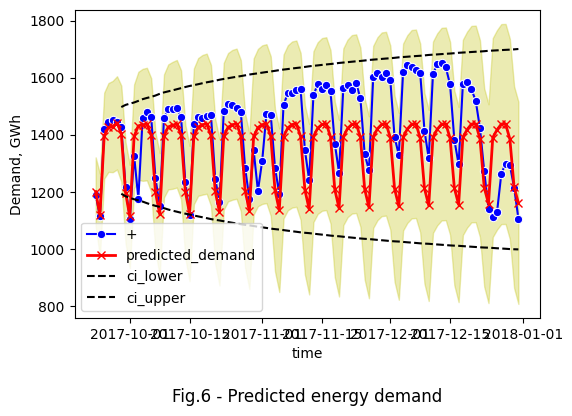

In [ ]:
fig_id = 6
import matplotlib.ticker as ticker
x = np.arange(2019,2022).astype('int16') #list(pd.to_datetime(prediction_arima.index).year.values)

plt.figure(figsize=(6,4))
fig = sns.lineplot(prediction_arima['y'], c='b', label='+', marker='o') #  lw=1
plt.plot(prediction_arima['y_hat'], 'x-r', label='predicted_demand', lw=2)
plt.plot(prediction_arima[['ci_lower','ci_upper']].rolling(window=7).mean(),'--k',label=['ci_lower','ci_upper'])
plt.fill_between(prediction_arima.index, prediction_arima['ci_lower'].values, prediction_arima['ci_upper'].values, color='y', alpha=0.3)

#plt.xticks(np.arange(2019,2022))

#scale_factor_y = 1e9
#ticks_y = ticker.FuncFormatter(lambda y, pos: '{:.0f}'.format(y/scale_factor_y))
#fig.yaxis.set_major_formatter(ticks_y)#
plt.ylabel("GDP, billions usd")

plt.legend()
plt.title("Fig.{} - Predicted energy demand".format(fig_id), y=-0.3)
plt.ylabel("Demand, GWh")
plt.show();

### Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


poly = PolynomialFeatures(degree=2, include_bias=False)
poly.fit(X_train_scaled)

X_train_scaled_poly = poly.transform(X_train_scaled)
X_test_scaled_poly = poly.transform(X_test_scaled)

model = LinearRegression()
model.fit(X_train_scaled_poly, y_train)
y_pred = model.predict(X_test_scaled_poly)

print('MSE score:  {:.3f}'.format(mean_squared_error(y_pred, y_test)))
print('MAPE score: {:.3f}'.format(mean_absolute_percentage_error(y_pred, y_test)))

MSE score:  17802.401
MAPE score: 0.076


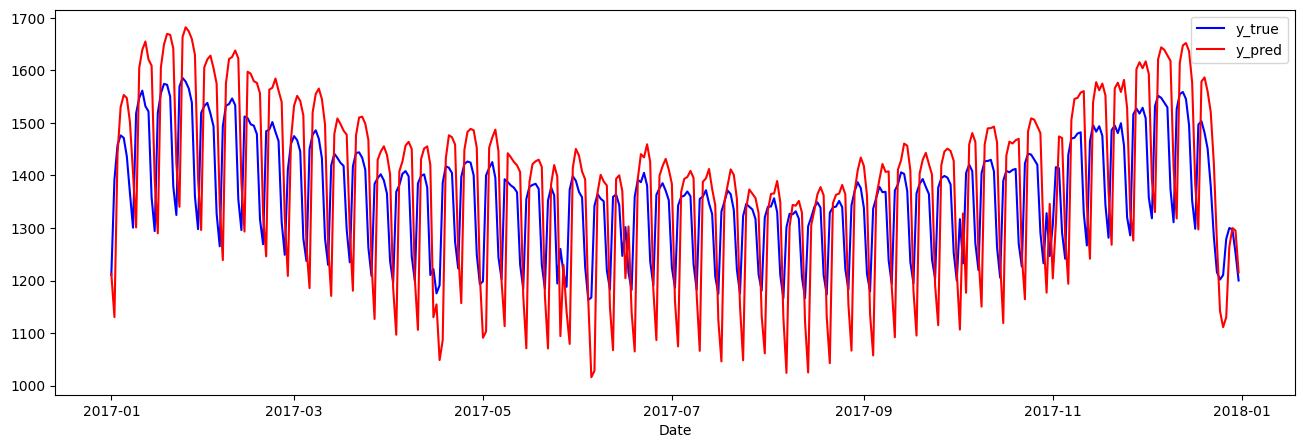

In [ ]:
period = '2017-01-01'
length = X_test.loc[period:,:].shape[0]

plt.figure(figsize=(16,5))
#sns.lineplot(test_data, x=test_data.index, y='Consumption', label='y_test')
sns.lineplot(x=X_test.loc[period:,:].index, y=y_pred.reshape(-1,)[-length:], c='b', label='y_true');
sns.lineplot(x=X_test.loc[period:,:].index, y=y_test.reshape(-1,)[-length:], c='r', label='y_pred');
 